# ライブラリのインポート

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import datasets

# 関数定義

In [26]:
# デバッグ用関数
def DEBUG_PRINT(text, value):
    print("※※※ " + text + " ※※※")
    print(value)
    print("")

# 正規化用関数
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)

# レイヤークラス

In [27]:
# ReLU layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        # mask.shape = x.shape
        # True or Falseを要素として持つ
        self.mask = (x <= 0)
        out = x.copy()
        # Trueの箇所を0にする
        out[self.mask] = 0

        return out

    def backward(self, dout):
        # Trueの箇所を0にする
        dout[self.mask] = 0
        dx = dout

        return dx

# Affine layer(全結合 layer)
class Affine:
    
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out

    def backward(self, dout):
        batch_size = dout.shape[0]
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)/batch_size
        self.db = np.sum(dout, axis=0)/batch_size

        return dx

# 出力層
class IdentityMapping:
    def __init__(self):
        self.y = None       # 恒等写像の出力
        self.d = None       # 教師データ

    def forward(self, x, d):
        self.d = d
        self.y = x
        return  self.y

    def backward(self, dout=1):
        return self.y - self.d

# ネットワーククラス

In [28]:
class TwoLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size: 隠れ層のノード数
    output_size: 出力層のノード数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.3):
        # 重みの初期化
        self.params = {}
        self.params['W2'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        
        self.lastLayer = IdentityMapping()
        
    # 順伝播
    def predict(self, x, d):
        for layer in self.layers.values():
            x = layer.forward(x)
        y = self.lastLayer.forward(x, d)
        return y
        
    # 誤差
    def loss(self, x, d):
        y = self.predict(x, d)
        return np.sum(np.square(d - y)) / 2
             
    # 勾配
    def gradient(self, x, d):
        # 順伝播 
        y = self.predict(x, d)

        # 逆伝播
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W2'], grad['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grad['W3'], grad['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grad

# その他、事前準備

In [29]:
# 乱数準備
np.random.seed(1)

# データの準備

In [30]:
# データセットのロード
iris = datasets.load_iris()

# Pandas のデータフレームとして表示
# sepal length (cm) : がく片の長さ
# sepal width (cm) : がく片の幅
# petal length (cm) : 花弁の長さ
# petal width (cm) : 花弁の幅 ⇒ 目的変数
# pd.DataFrame(iris.data, columns=iris.feature_names)

In [31]:
# 説明変数
x_vals = np.array([x[0:3] for x in iris.data])
# DEBUG_PRINT("説明変数", x_vals)

# 目的変数
y_vals = np.array([x[3] for x in iris.data])
y_vals = np.transpose([y_vals])
# DEBUG_PRINT("目的変数", y_vals)
# x_vals_train, x_vals_test, y_vals_train, y_vals_test = train_test_split(x_vals, y_vals, test_size=0.2, random_state=0,)

In [32]:
# ８割のデータをトレーニングセットに設定
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)

# 残りのデータをテストセットに設定
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

In [33]:
# トレーニングデータ
x_vals_train = x_vals[train_indices]
# DEBUG_PRINT("トレーニングデータ [x_vals_train]", x_vals_train)

y_vals_train = y_vals[train_indices]
# DEBUG_PRINT("トレーニングデータ [y_vals_train]", y_vals_train)

In [34]:
# テストデータ
x_vals_test = x_vals[test_indices]
# DEBUG_PRINT("トレーニングデータ [x_vals_test]", x_vals_test)
y_vals_test = y_vals[test_indices]
# DEBUG_PRINT("トレーニングデータ [y_vals_test]", y_vals_test)

In [35]:
# 正規化と欠損値処理
# x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
# DEBUG_PRINT("トレーニングデータ [x_vals_train]", x_vals_train)
# x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))
# DEBUG_PRINT("トレーニングデータ [x_vals_test]", x_vals_test)

# トレーニング

Generation: 100. 最小二乗誤差（トレーニング）= 0.6857712855872002
                   : 100. 最小二乗誤差（テスト）= 1.5171377128169372
Generation: 200. 最小二乗誤差（トレーニング）= 1.4668442068854763
                   : 200. 最小二乗誤差（テスト）= 1.4988945370421178
Generation: 300. 最小二乗誤差（トレーニング）= 1.2171020368235224
                   : 300. 最小二乗誤差（テスト）= 1.3331365509328617
Generation: 400. 最小二乗誤差（トレーニング）= 1.2888347021300572
                   : 400. 最小二乗誤差（テスト）= 1.2572691321425928
Generation: 500. 最小二乗誤差（トレーニング）= 1.871496721890381
                   : 500. 最小二乗誤差（テスト）= 1.2338903980084832
Generation: 600. 最小二乗誤差（トレーニング）= 1.2146294168845715
                   : 600. 最小二乗誤差（テスト）= 1.205791352846272
Generation: 700. 最小二乗誤差（トレーニング）= 1.3394065369165515
                   : 700. 最小二乗誤差（テスト）= 1.1715914849405298
Generation: 800. 最小二乗誤差（トレーニング）= 1.3676148675543425
                   : 800. 最小二乗誤差（テスト）= 1.1807524982393847
Generation: 900. 最小二乗誤差（トレーニング）= 1.4767797829145637
                   : 900. 最小二乗誤差（テスト）= 1.0640412987993062
Generation: 

                   : 7900. 最小二乗誤差（テスト）= 0.6928444964352866
Generation: 8000. 最小二乗誤差（トレーニング）= 0.40970461732255414
                   : 8000. 最小二乗誤差（テスト）= 0.6833252019238851
Generation: 8100. 最小二乗誤差（トレーニング）= 0.4931267899541646
                   : 8100. 最小二乗誤差（テスト）= 0.6529719284567019
Generation: 8200. 最小二乗誤差（トレーニング）= 0.7322188207373403
                   : 8200. 最小二乗誤差（テスト）= 0.653487514991596
Generation: 8300. 最小二乗誤差（トレーニング）= 0.6308437819081177
                   : 8300. 最小二乗誤差（テスト）= 0.6608418941965722
Generation: 8400. 最小二乗誤差（トレーニング）= 0.5235122485766533
                   : 8400. 最小二乗誤差（テスト）= 0.683455961398511
Generation: 8500. 最小二乗誤差（トレーニング）= 0.9802227974153127
                   : 8500. 最小二乗誤差（テスト）= 0.683852432680255
Generation: 8600. 最小二乗誤差（トレーニング）= 0.2454099950716648
                   : 8600. 最小二乗誤差（テスト）= 0.6445077699592412
Generation: 8700. 最小二乗誤差（トレーニング）= 0.488743038696698
                   : 8700. 最小二乗誤差（テスト）= 0.6439121306202163
Generation: 8800. 最小二乗誤差（トレーニング）= 0.505672740419

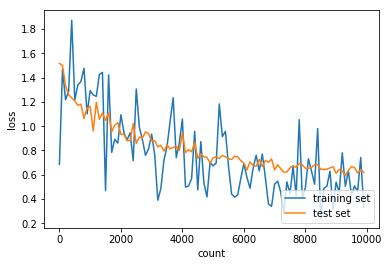

In [36]:
# ネットワークの初期化
network = TwoLayerNet(input_size=3, hidden_size=30, output_size=1)

ls_train = []
ls_test = []

batch_size = 30 # バッチサイズ
epoch = 10000 #学習回数
learning_rate = 0.001 # 学習率

plot_interval=100 # 描写頻度

# 学習
for i in range(epoch):
    
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(len(x_vals_train), size=batch_size)
    
    # ミニバッチに対応する教師訓練データを取得    
    x_batch = x_vals_train[batch_mask]
    
    # ミニバッチに対応する訓練正解データを取得する
    d_batch = y_vals_train[batch_mask]

    #  順伝播と逆伝播
    grad = network.gradient(x_batch, d_batch)
    
    # パラメータ最適化
    for key in ('W2', 'W3', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    # 誤差を記録
    if (i+1)%plot_interval==0:
        
        # トレーニングデータの誤差
        ls_train_temp = network.loss(x_batch, d_batch)
        ls_train.append(ls_train_temp)
        print('Generation: ' + str(i+1) + '. 最小二乗誤差（トレーニング）= ' + str(ls_train_temp))      
        
        # テストデータの誤差
        ls_test_temp = network.loss(x_vals_test, y_vals_test)
        ls_test.append(ls_test_temp)
        print('                   : ' + str(i+1) + '. 最小二乗誤差（テスト）= ' + str(ls_test_temp))

lists = range(0, epoch, plot_interval)
plt.plot(lists, ls_train, label="training set")
plt.plot(lists, ls_test,  label="test set")
plt.legend(loc="lower right")
plt.xlabel("count")
plt.ylabel("loss")
# グラフの表示
plt.show()